In [1]:
#importing libraries
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("../data/transactions.csv")

## Exploratory Data Analysis

In [3]:
shape = df.shape

print(f"Our dataset has {shape[0]} rows and {shape[1]} columns.")

Our dataset has 299695 rows and 17 columns.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

In [5]:
## numerical columns statistics

df.describe()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,promo_used,avs_match,cvv_result,three_ds_flag,shipping_distance_km,is_fraud
count,299695.0000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000
mean,149848.0000,3002.559432,973.397871,50.673321,148.142973,177.165279,0.153640,0.837999,0.872110,0.784588,357.049028,0.022062
std,86514.6388,1732.309663,525.241409,5.976391,200.364624,306.926507,0.360603,0.368453,0.333968,0.411109,427.672074,0.146887
min,1.0000,1.000000,1.000000,40.000000,3.520000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74924.5000,1501.000000,516.000000,46.000000,46.190000,42.100000,0.000000,1.000000,1.000000,1.000000,136.600000,0.000000
50%,149848.0000,3007.000000,975.000000,51.000000,90.130000,89.990000,0.000000,1.000000,1.000000,1.000000,273.020000,0.000000
75%,224771.5000,4504.000000,1425.000000,56.000000,173.450000,191.110000,0.000000,1.000000,1.000000,1.000000,409.180000,0.000000
max,299695.0000,6000.000000,1890.000000,60.000000,4565.290000,16994.740000,1.000000,1.000000,1.000000,1.000000,3748.560000,1.000000


In [6]:
#check for missing values

df.isnull().sum()

transaction_id             0
user_id                    0
account_age_days           0
total_transactions_user    0
avg_amount_user            0
amount                     0
country                    0
bin_country                0
channel                    0
merchant_category          0
promo_used                 0
avs_match                  0
cvv_result                 0
three_ds_flag              0
transaction_time           0
shipping_distance_km       0
is_fraud                   0
dtype: int64

In [7]:
## check for duplicate values

df['transaction_id'].duplicated().value_counts()

transaction_id
False    299695
Name: count, dtype: int64

In [8]:
# target variable
df['is_fraud'].value_counts()

is_fraud
0    293083
1      6612
Name: count, dtype: int64

In [9]:
df['is_fraud'].value_counts(normalize=True)*100

is_fraud
0    97.793757
1     2.206243
Name: proportion, dtype: float64

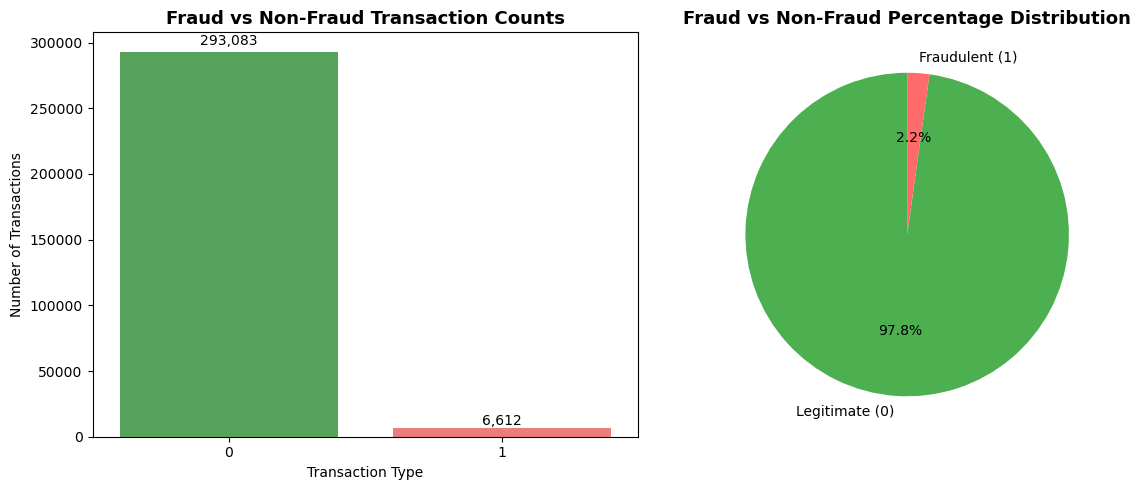

In [26]:
# 🎯 Step 2: Visualize target variable distribution (is_fraud) — updated for seaborn 0.14+

import matplotlib.pyplot as plt
import seaborn as sns

fraud_counts = df['is_fraud'].value_counts().sort_index()
fraud_labels = ['Legitimate (0)', 'Fraudulent (1)']

# Prepare a small DataFrame for plotting
fraud_df = pd.DataFrame({
    'is_fraud': fraud_counts.index,
    'count': fraud_counts.values
})

# Create a figure with two subplots: bar + pie
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1️⃣ Bar Chart (updated style)
sns.barplot(
    data=fraud_df,
    x='is_fraud',
    y='count',
    hue='is_fraud',        # assign hue for colors
    palette=['#4CAF50', '#FF6B6B'],
    legend=False,
    ax=axes[0]
)
axes[0].set_title('Fraud vs Non-Fraud Transaction Counts', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Transaction Type')
axes[0].set_ylabel('Number of Transactions')

# Add text labels on bars
for i, count in enumerate(fraud_counts.values):
    axes[0].text(i, count + (count * 0.01), f'{count:,}', ha='center', va='bottom', fontsize=10)

# 2️⃣ Pie Chart
axes[1].pie(fraud_counts.values, labels=fraud_labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FF6B6B'])
axes[1].set_title('Fraud vs Non-Fraud Percentage Distribution', fontsize=13, fontweight='bold')

# Save the visualization
plt.tight_layout()
plt.savefig("../images/fraud_distribution.png", dpi=300, bbox_inches='tight')
plt.show()